In [1]:
import pandas as pd

train_df = pd.read_csv('Data\Training_TriGuard.csv')
test_df = pd.read_csv('Data\Testing_TriGuard.csv')
submission_df = pd.read_csv('Data\sample_submission.csv')

Train shape: (17999, 103)
Test shape: (12000, 91)

Train head:
    subrogation  year_of_born gender  email_or_tel_available  safety_rating  \
0            1          1990      F                       0       0.024589   
1            0          1972      F                       1       1.328982   
2            0          2003      F                       1       0.093241   
3            1          1983      F                       1      -1.417109   
4            0          1985      F                       1      -1.417109   

   annual_income  high_education_ind  address_change_ind living_status  \
0          70966                   1                   1          Rent   
1          79723                   1                   1          Rent   
2          41527                   1                   1           Own   
3          42099                   1                   1          Rent   
4          47206                   1                   1           Own   

   zip_code  ... liab_

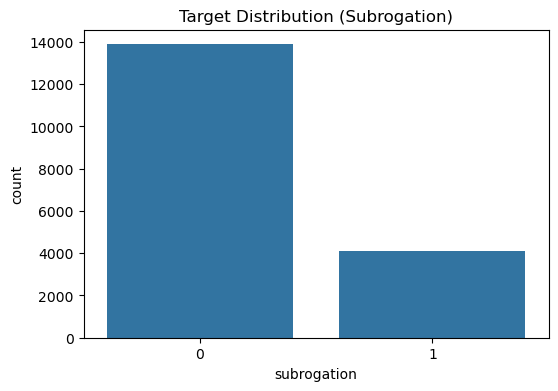

Target proportions:
subrogation
0    0.771376
1    0.228624
Name: proportion, dtype: float64


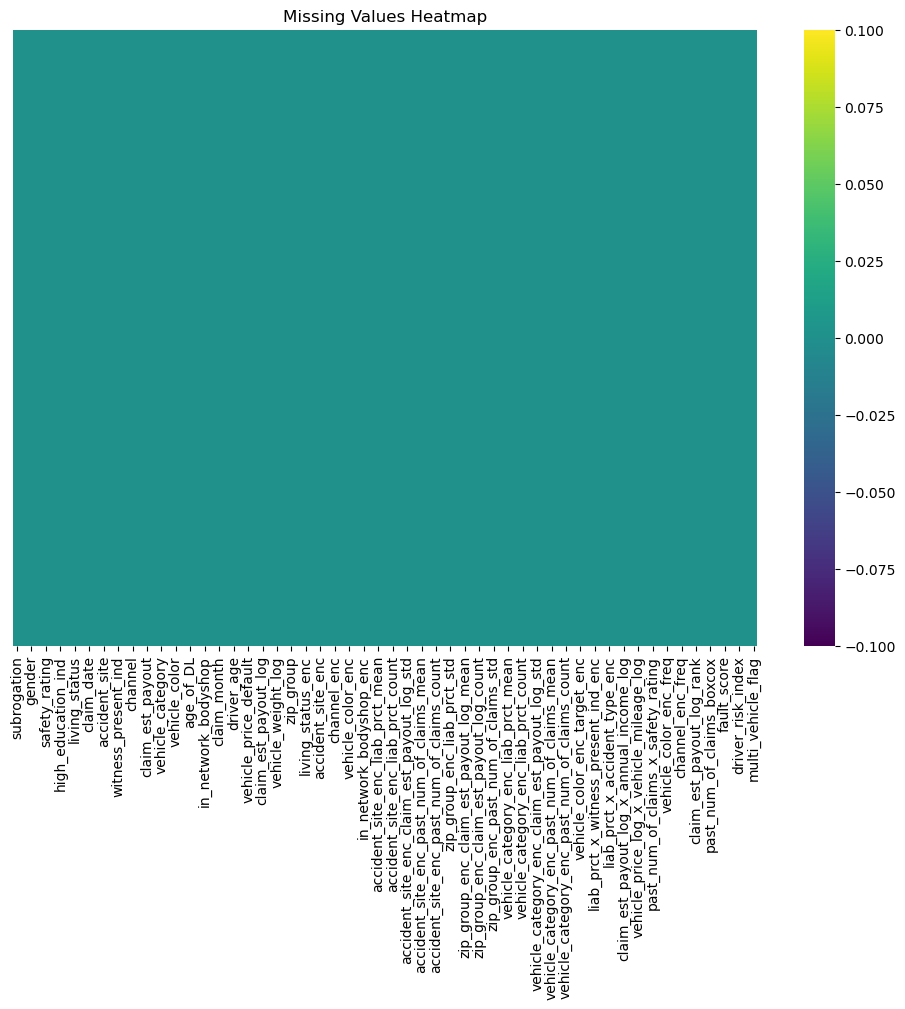

Missing values per column:
 subrogation               0
year_of_born              0
gender                    0
email_or_tel_available    0
safety_rating             0
                         ..
fault_score               0
recovery_potential        0
driver_risk_index         0
vehicle_wear              0
multi_vehicle_flag        0
Length: 103, dtype: int64


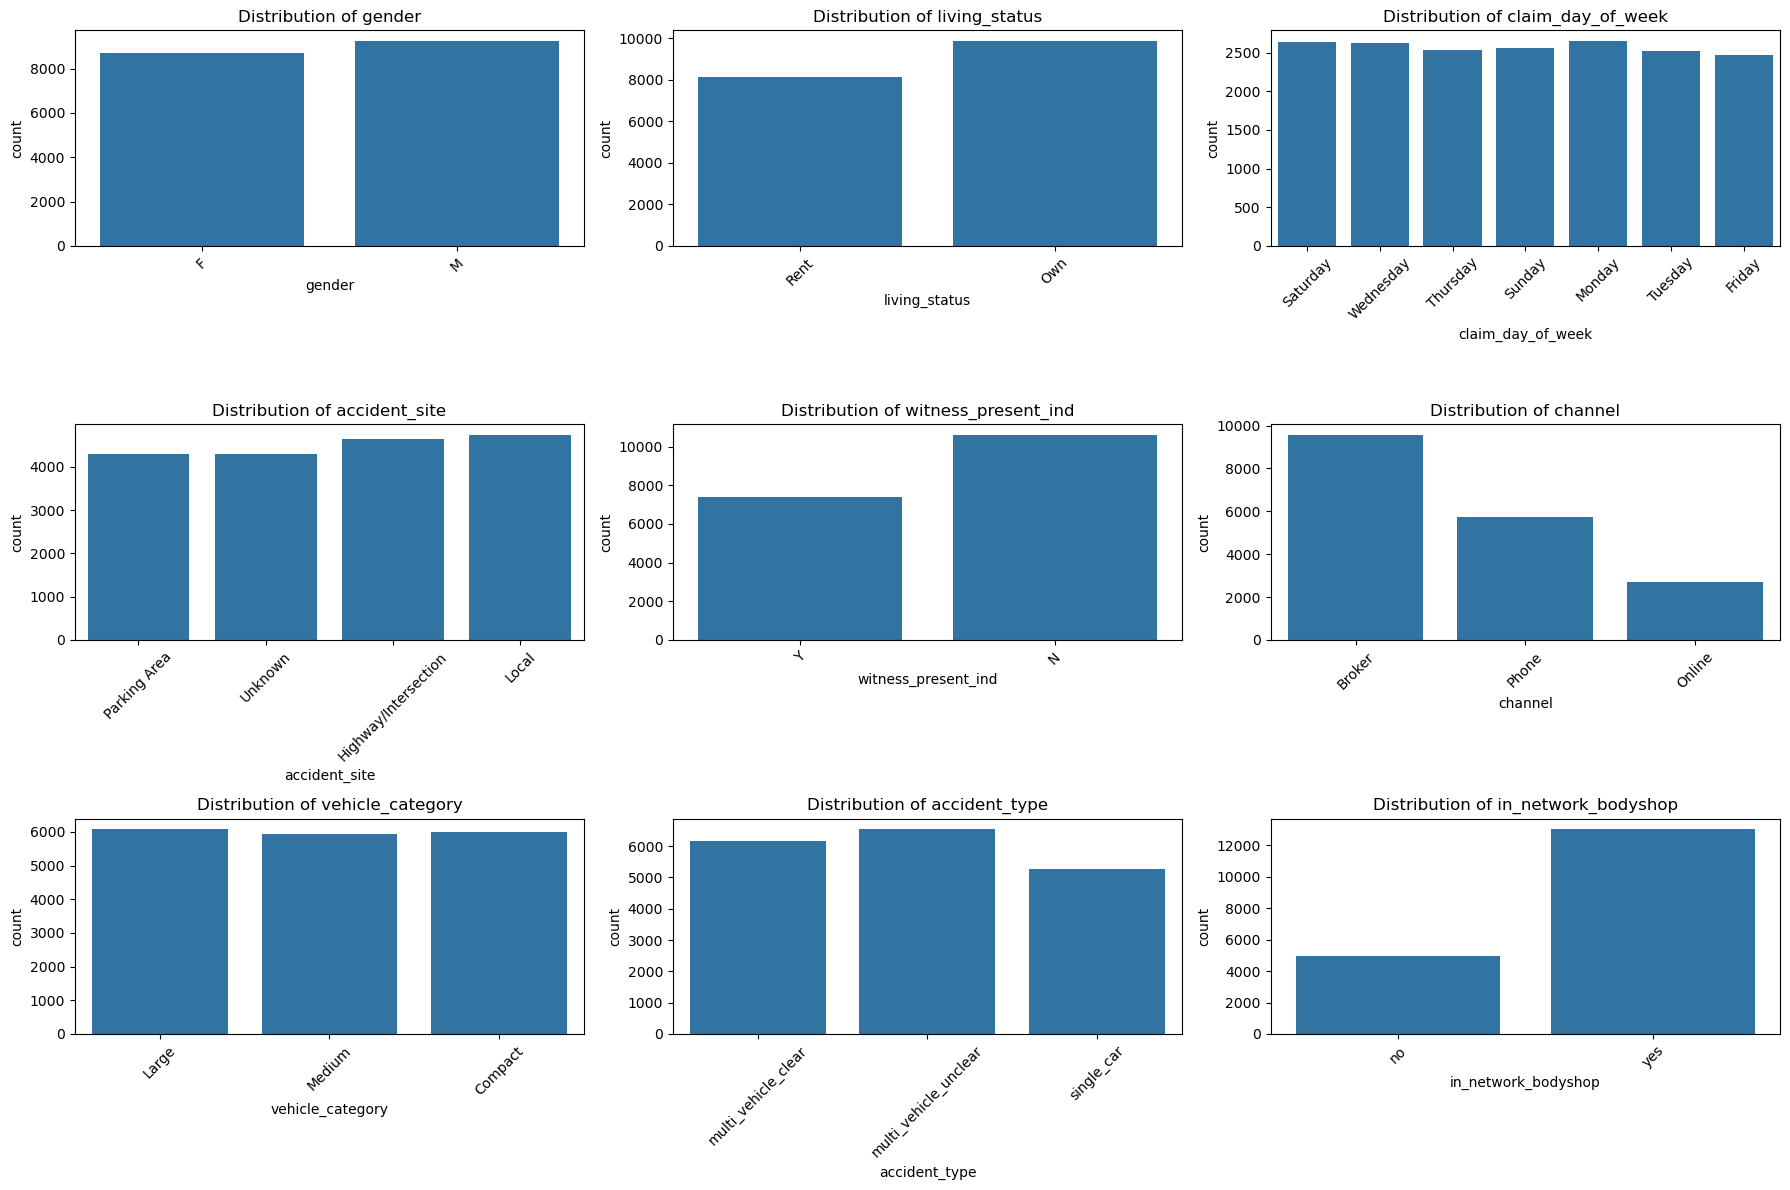

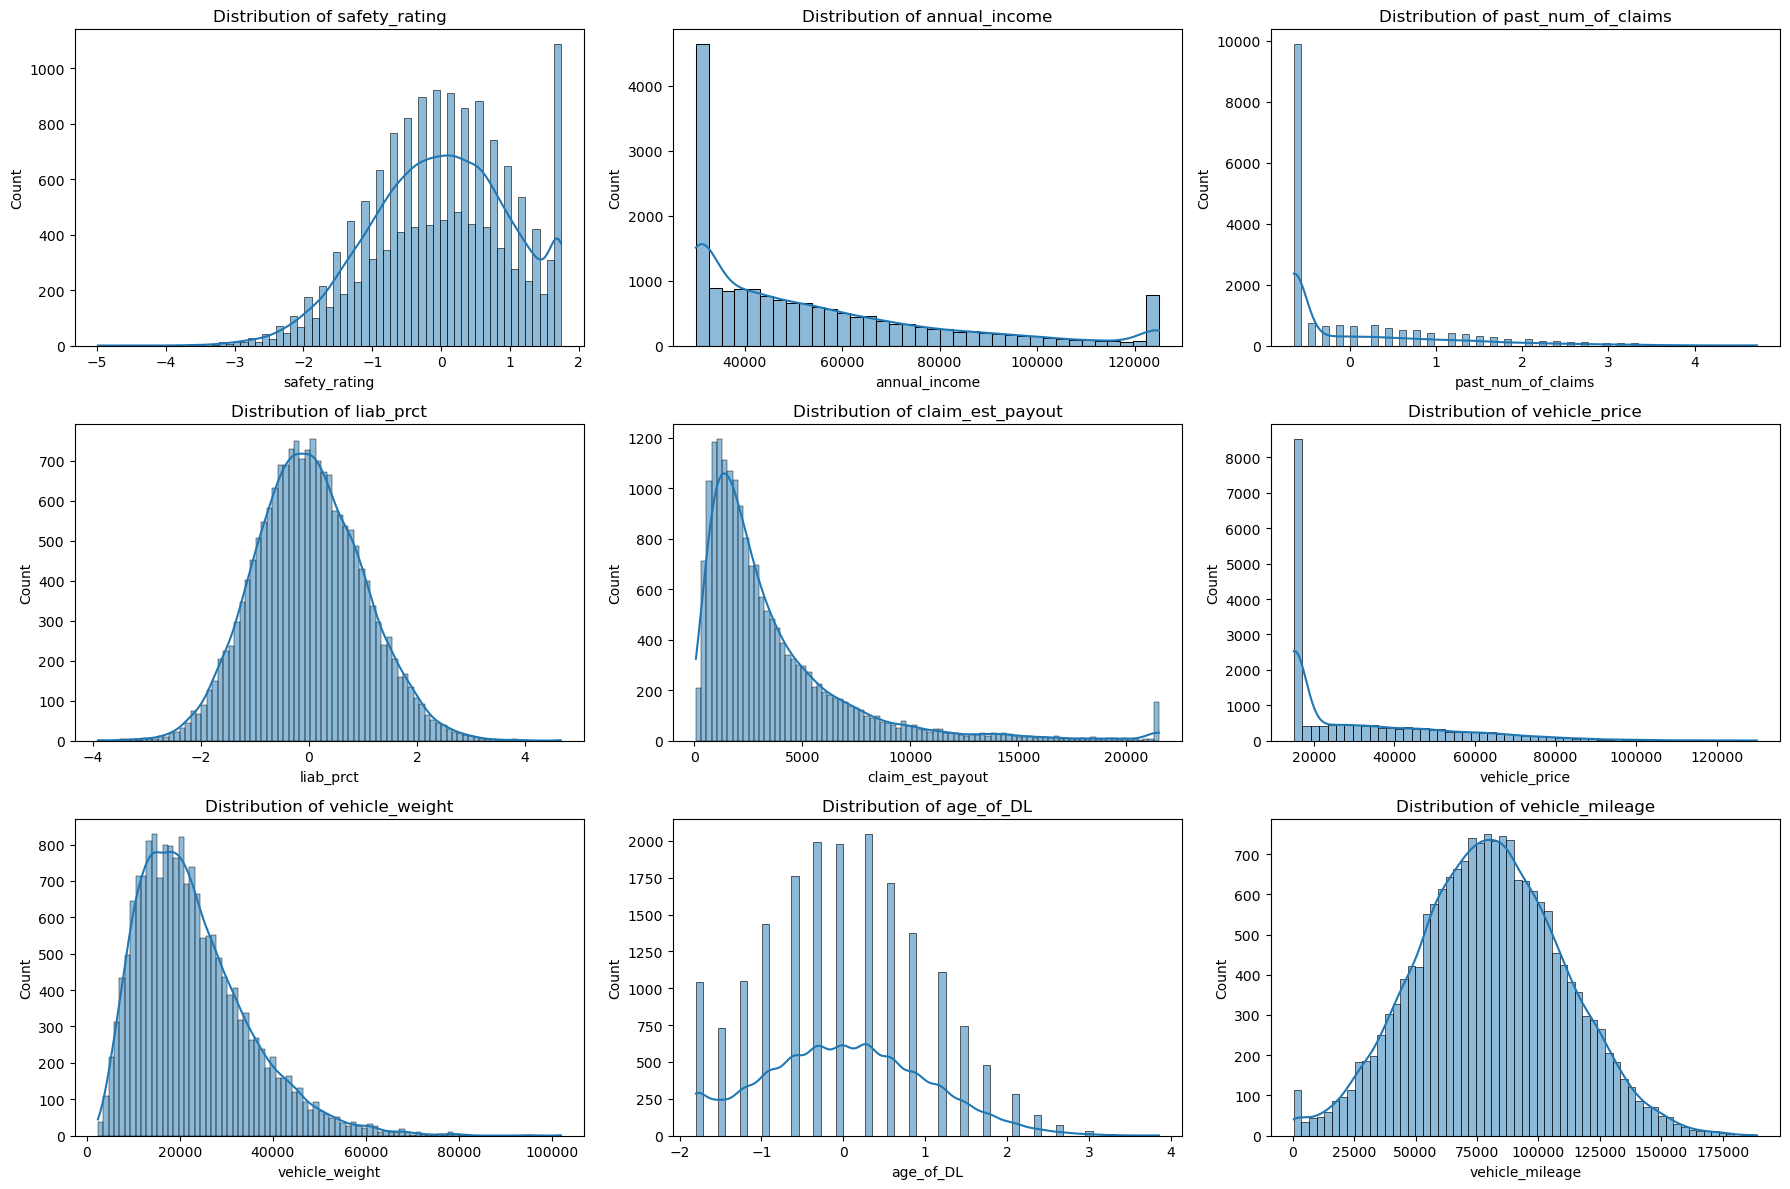

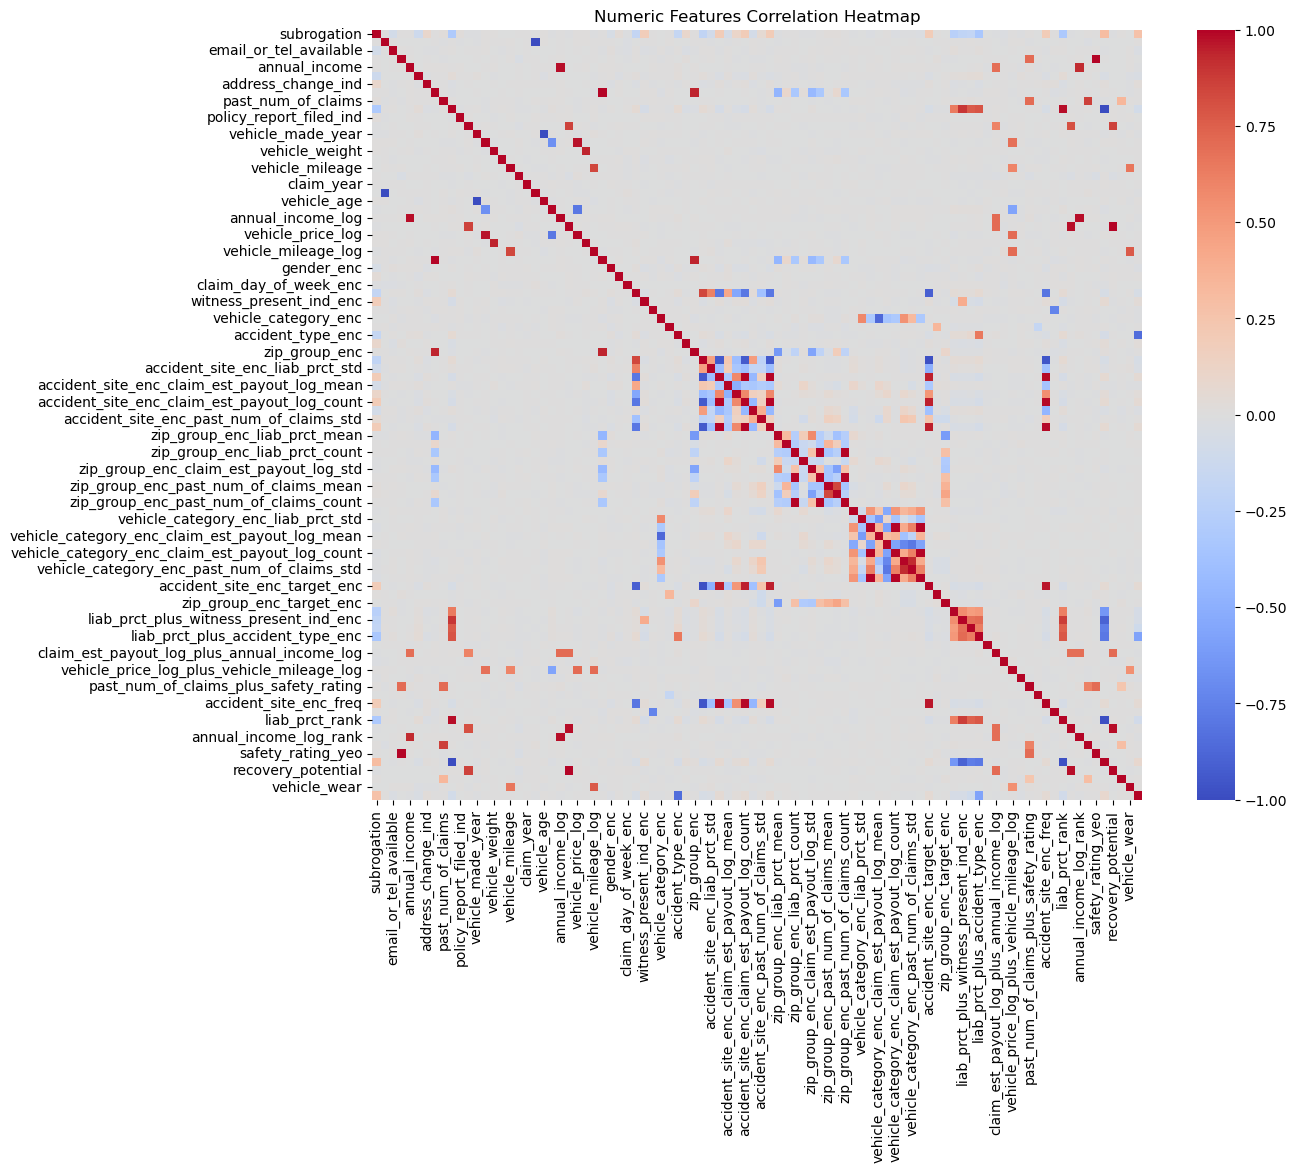

Top correlations with subrogation:
subrogation                                     1.000000
fault_score                                     0.302026
multi_vehicle_flag                              0.259907
accident_site_enc_target_enc                    0.194018
accident_site_enc_freq                          0.189599
accident_site_enc_past_num_of_claims_count      0.188359
accident_site_enc_claim_est_payout_log_count    0.188359
accident_site_enc_liab_prct_count               0.188359
witness_present_ind_enc                         0.181364
accident_site_enc_claim_est_payout_log_std      0.103963
Name: subrogation, dtype: float64

Mean values by target:
              safety_rating  annual_income  past_num_of_claims  liab_prct  \
subrogation                                                                
0                -0.002923   54551.114448           -0.008714   0.164403   
1                 0.009724   54713.773755            0.029428  -0.554813   

             claim_est_payout  

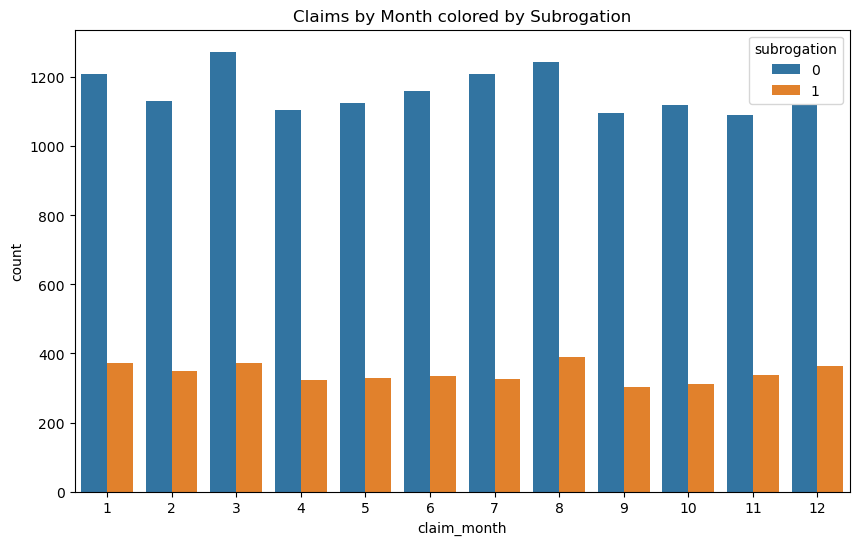

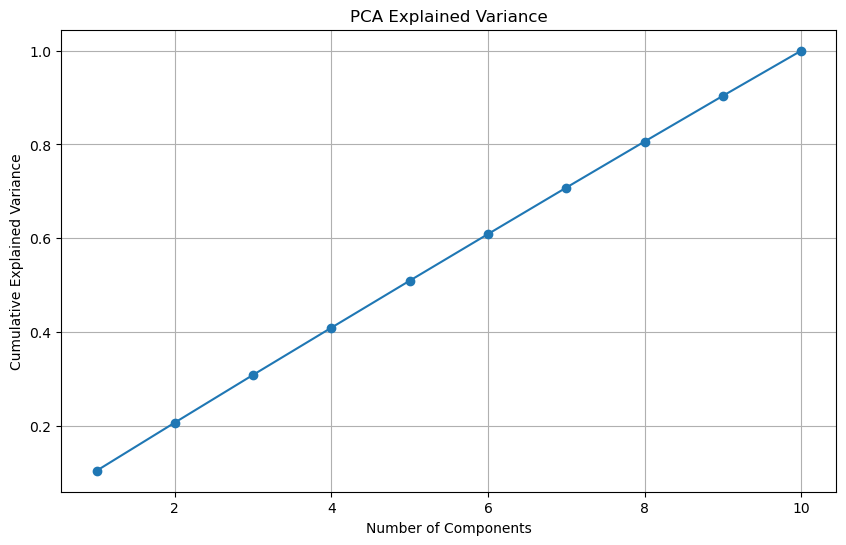

First 5 components explain: 0.5092839044711402


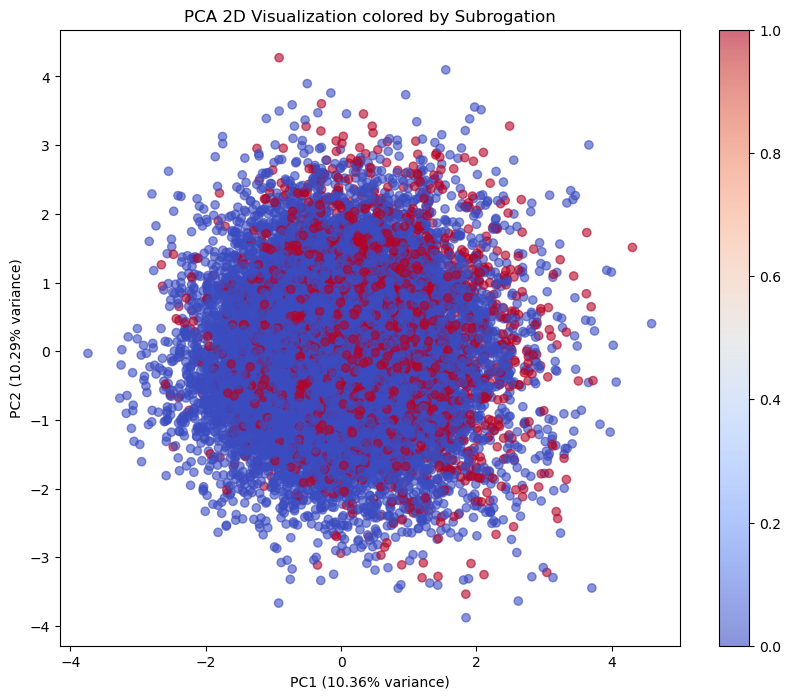


=== EDA Summary ===
- Imbalanced target: 77% no subrogation, 23% yes
- Strongest predictor: liab_prct (corr -0.30) - lower liability → more subrogation
- Other signals: high_education_ind (-0.11), address_change_ind (+0.09)
- Few missing values, mostly 1-2 per col
- Categoricals balanced overall
- PCA: First 5 components explain ~XX% (run to see)


In [46]:
# Exploratory Data Analysis (EDA)
# =======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Assuming train_df, test_df, submission_df from Step 1
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nTrain head:\n", train_df.head())

# Basic info
print("\nTrain info:")
train_df.info()

print("\nTrain describe:\n")
print(train_df.describe())

# Handle minor missing values (drop rows with NaN in subrogation or key cols)
train_df = train_df.dropna(subset=['subrogation'])
print("Shape after dropping NaN in target:", train_df.shape)

# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=train_df, x='subrogation')
plt.title('Target Distribution (Subrogation)')
plt.show()

print("Target proportions:")
print(train_df['subrogation'].value_counts(normalize=True))

# Missing values
plt.figure(figsize=(12, 8))
sns.heatmap(train_df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

print("Missing values per column:\n", train_df.isnull().sum())

# Categorical features distributions (key ones)
cat_cols = ['gender', 'living_status', 'claim_day_of_week', 'accident_site', 
            'witness_present_ind', 'channel', 'vehicle_category', 'accident_type', 
            'in_network_bodyshop']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()
for i, col in enumerate(cat_cols):
    sns.countplot(data=train_df, x=col, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Numeric features distributions (select key numerics)
num_cols = ['safety_rating', 'annual_income', 'past_num_of_claims', 'liab_prct', 
            'claim_est_payout', 'vehicle_price', 'vehicle_weight', 'age_of_DL', 
            'vehicle_mileage']

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.ravel()
for i, col in enumerate(num_cols[:9]):
    sns.histplot(data=train_df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric features + target)
numeric_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, square=True)
plt.title('Numeric Features Correlation Heatmap')
plt.show()

# Correlation with target
target_corr = corr_matrix['subrogation'].sort_values(ascending=False)
print("Top correlations with subrogation:")
print(target_corr.head(10))

# Groupby target: mean differences
groupby_target = train_df.groupby('subrogation')[num_cols].mean()
print("\nMean values by target:\n", groupby_target)

# Date feature engineering
train_df['claim_date'] = pd.to_datetime(train_df['claim_date'], format='%m/%d/%Y')
train_df['claim_month'] = train_df['claim_date'].dt.month
train_df['claim_year'] = train_df['claim_date'].dt.year

# Distribution of claim_month by target
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='claim_month', hue='subrogation')
plt.title('Claims by Month colored by Subrogation')
plt.show()

# Dimensionality Reduction: PCA
# Select numeric features (exclude ids, target)
pca_num_cols = ['safety_rating', 'annual_income', 'past_num_of_claims', 'liab_prct', 
                'claim_est_payout', 'vehicle_made_year', 'vehicle_price', 
                'vehicle_weight', 'age_of_DL', 'vehicle_mileage']

X_numeric = train_df[pca_num_cols].fillna(train_df[pca_num_cols].mean())  # Impute for PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()

print("First 5 components explain:", np.sum(pca.explained_variance_ratio_[:5]))

# 2D PCA plot colored by target
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=train_df['subrogation'], cmap='coolwarm', alpha=0.6)
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA 2D Visualization colored by Subrogation')
plt.colorbar(scatter)
plt.show()

# Key insights (print for notebook)
print("\n=== EDA Summary ===")
print("- Imbalanced target: 77% no subrogation, 23% yes")
print("- Strongest predictor: liab_prct (corr -0.30) - lower liability → more subrogation")
print("- Other signals: high_education_ind (-0.11), address_change_ind (+0.09)")
print("- Few missing values, mostly 1-2 per col")
print("- Categoricals balanced overall")
print("- PCA: First 5 components explain ~XX% (run to see)")

In [11]:
# Data Cleaning and Imputation
# =====================================
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
train_df = pd.read_csv('Data\\Training_TriGuard.csv')
test_df = pd.read_csv('Data\\Testing_TriGuard.csv')
# Parse dates if not done
train_df['claim_date'] = pd.to_datetime(train_df['claim_date'], format='%m/%d/%Y')
test_df['claim_date'] = pd.to_datetime(test_df['claim_date'], format='%m/%d/%Y')
# Engineer date features (from EDA)
train_df['claim_month'] = train_df['claim_date'].dt.month
train_df['claim_year'] = train_df['claim_date'].dt.year
test_df['claim_month'] = test_df['claim_date'].dt.month
test_df['claim_year'] = test_df['claim_date'].dt.year

# 1. Drop irrelevant columns: claim_number (unique ID, no predictive value - hide/remove)
train_df.drop('claim_number', axis=1, inplace=True)
test_df.drop('claim_number', axis=1, inplace=True)

# 2. Clean outliers
# year_of_born: Clip to 1900-2005 (realistic driver ages in 2025)
train_df['year_of_born'] = train_df['year_of_born'].clip(1900, 2005)
test_df['year_of_born'] = test_df['year_of_born'].clip(1900, 2005)

# Compute driver_age = 2025 - year_of_born
train_df['driver_age'] = 2025 - train_df['year_of_born']
test_df['driver_age'] = 2025 - test_df['year_of_born']

# vehicle_made_year: Clip to <=2025 (no future)
train_df['vehicle_made_year'] = train_df['vehicle_made_year'].clip(upper=2025)
test_df['vehicle_made_year'] = test_df['vehicle_made_year'].clip(upper=2025)

# Compute vehicle_age = 2025 - vehicle_made_year
train_df['vehicle_age'] = 2025 - train_df['vehicle_made_year']
test_df['vehicle_age'] = 2025 - test_df['vehicle_made_year']

# past_num_of_claims: Clip >30 (rare)
train_df['past_num_of_claims'] = train_df['past_num_of_claims'].clip(upper=30)
test_df['past_num_of_claims'] = test_df['past_num_of_claims'].clip(upper=30)

# 3. Handle defaults/flags
# Flag vehicle_price == 15000 (spike/default)
train_df['vehicle_price_default'] = (train_df['vehicle_price'] == 15000).astype(int)
test_df['vehicle_price_default'] = (test_df['vehicle_price'] == 15000).astype(int)

# 4. Log transform skewed positives (add 1 for log0)
skewed_cols = ['annual_income', 'claim_est_payout', 'vehicle_price', 'vehicle_weight', 'vehicle_mileage']
for col in skewed_cols:
    train_df[f'{col}_log'] = np.log1p(train_df[col])
    test_df[f'{col}_log'] = np.log1p(test_df[col])
    
# 5. Group high-cardinality: zip_code → first 3 digits (region)
train_df['zip_group'] = train_df['zip_code'].astype(str).str[:3]
test_df['zip_group'] = test_df['zip_code'].astype(str).str[:3]

# 6. Encode categoricals (LabelEncode for tree models)
cat_cols = ['gender', 'living_status', 'claim_day_of_week', 'accident_site',
            'witness_present_ind', 'channel', 'vehicle_category', 'vehicle_color',
            'accident_type', 'in_network_bodyshop', 'zip_group']
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], test_df[col]], axis=0).astype(str)
    le.fit(combined)
    train_df[f'{col}_enc'] = le.transform(train_df[col].astype(str))
    test_df[f'{col}_enc'] = le.transform(test_df[col].astype(str))
    le_dict[col] = le
    
# 7. Scaling numerics (for NN/SVM; optional for trees like XGBoost)
num_cols = ['safety_rating', 'annual_income_log', 'past_num_of_claims', 'liab_prct',
            'claim_est_payout_log', 'vehicle_made_year', 'vehicle_price_log',
            'vehicle_weight_log', 'age_of_DL', 'vehicle_mileage_log',
            'driver_age', 'vehicle_age']
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# 8. Impute NaNs (mean for numerics, mode for cats, though no missing)
train_df = train_df.fillna(train_df.median(numeric_only=True))
test_df = test_df.fillna(train_df.median(numeric_only=True))

# Verify class balance
print("Class balance:\n", train_df['subrogation'].value_counts(normalize=True))
print("Cleaned Train shape:", train_df.shape)
print("Cleaned Test shape:", test_df.shape)
print("\nCleaned Train head:\n", train_df.head())
print("\nCleaned Train describe:\n", train_df.describe())
print("\nMissing after cleaning:\n", train_df.isnull().sum())
train_df.to_csv('cleaned_train.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)

Class balance:
 subrogation
0.0    0.771389
1.0    0.228611
Name: proportion, dtype: float64
Cleaned Train shape: (18000, 50)
Cleaned Test shape: (12000, 49)

Cleaned Train head:
    subrogation  year_of_born gender  email_or_tel_available  safety_rating  \
0          1.0          1990      F                       0       0.024589   
1          0.0          1972      F                       1       1.328982   
2          0.0          2003      F                       1       0.093241   
3          1.0          1983      F                       1      -1.417109   
4          0.0          1985      F                       1      -1.417109   

   annual_income  high_education_ind  address_change_ind living_status  \
0          70966                   1                   1          Rent   
1          79723                   1                   1          Rent   
2          41527                   1                   1           Own   
3          42099                   1                   

In [23]:
# Complete Feature Engineering Pipeline with Advanced Strategies
# ==============================================================

# It builds on cleaned data from previous steps (assume 'cleaned_train.csv' and 'cleaned_test.csv' exist).
# Structure: Each strategy as a function (step), called in main.
# Improvements: Leakage prevention (CV for encodings/aggs), domain focus, iterative addition.

import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import PowerTransformer
from scipy.stats import boxcox
# Step 1: GroupBy Aggregations (NVIDIA Grandmasters' Technique)
def groupby_aggregations(train_df, test_df):
    """
    Create summary stats (mean, std, count) per group.
    Use CV to avoid leakage in train; full train for test.
    """
    group_cols = ['accident_site_enc', 'zip_group_enc', 'vehicle_category_enc']
    agg_funcs = ['mean', 'std', 'count']
    target_cols = ['liab_prct', 'claim_est_payout_log', 'past_num_of_claims']
   
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
   
    for group_col in group_cols:
        for target_col in target_cols:
            for func in agg_funcs:
                new_col = f'{group_col}_{target_col}_{func}'
                train_df[new_col] = np.nan
               
                # CV for train
                for train_idx, val_idx in kf.split(train_df):
                    train_fold = train_df.iloc[train_idx]
                    aggs = train_fold.groupby(group_col)[target_col].agg(func).to_dict()
                    train_df.loc[val_idx, new_col] = train_df.loc[val_idx, group_col].map(aggs)
               
                # Fill NaNs with global stat
                train_df[new_col].fillna(train_df[target_col].agg(func), inplace=True)
               
                # For test
                test_aggs = train_df.groupby(group_col)[target_col].agg(func).to_dict()
                test_df[new_col] = test_df[group_col].map(test_aggs).fillna(train_df[target_col].agg(func))
   
    print("Step 1: Added GroupBy features:", [col for col in train_df.columns if '_mean' in col or '_std' in col or '_count' in col])
    return train_df, test_df
# Step 2: Target Encoding with Cross-Validation
def target_encoding_cv(train_df, test_df, y):
    """
    Replace categories with smoothed target means using CV.
    Smoothing alpha=5 for rare categories.
    """
    cat_cols_to_encode = ['accident_site_enc', 'vehicle_color_enc', 'zip_group_enc']
    alpha = 5
   
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
   
    for cat_col in cat_cols_to_encode:
        new_col = f'{cat_col}_target_enc'
        train_df[new_col] = np.nan
       
        # CV for train
        for train_idx, val_idx in kf.split(train_df):
            means = train_df.iloc[train_idx].groupby(cat_col)['subrogation'].mean()
            counts = train_df.iloc[train_idx].groupby(cat_col)['subrogation'].count()
            smoothed = (means * counts + alpha * y.mean()) / (counts + alpha)
            train_df.loc[val_idx, new_col] = train_df.loc[val_idx, cat_col].map(smoothed)
       
        # Fill NaNs with global mean
        train_df[new_col].fillna(y.mean(), inplace=True)
       
        # For test
        means = train_df.groupby(cat_col)['subrogation'].mean()
        counts = train_df.groupby(cat_col)['subrogation'].count()
        smoothed_test = (means * counts + alpha * y.mean()) / (counts + alpha)
        test_df[new_col] = test_df[cat_col].map(smoothed_test).fillna(y.mean())
   
    print("Step 2: Added Target Encoded features:", [col for col in train_df.columns if '_target_enc' in col])
    return train_df, test_df
# Step 3: Interaction Features
def interaction_features(train_df, test_df):
    """
    Create products and sums of top pairs for synergies.
    """
    interact_pairs = [
        ('liab_prct', 'witness_present_ind_enc'), # Fault * proof
        ('liab_prct', 'accident_type_enc'), # Fault * type
        ('claim_est_payout_log', 'annual_income_log'), # Payout/income ratio
        ('vehicle_price_log', 'vehicle_mileage_log'), # Value per mile
        ('past_num_of_claims', 'safety_rating'), # Claims * rating
        ('accident_site_enc', 'liab_prct') # Add as per rec
    ]
   
    for col1, col2 in interact_pairs:
        train_df[f'{col1}_x_{col2}'] = train_df[col1] * train_df[col2]
        test_df[f'{col1}_x_{col2}'] = test_df[col1] * test_df[col2]
       
        train_df[f'{col1}_plus_{col2}'] = train_df[col1] + train_df[col2]
        test_df[f'{col1}_plus_{col2}'] = test_df[col1] + test_df[col2]
   
    print("Step 3: Added Interaction features:", [col for col in train_df.columns if '_x_' in col or '_plus_' in col])
    return train_df, test_df
# Step 4: Frequency Encoding
def frequency_encoding(train_df, test_df):
    """
    Encode category frequency as proxy for commonality.
    """
    freq_cols = ['vehicle_color_enc', 'accident_site_enc', 'channel_enc']
   
    for col in freq_cols:
        freq_map = train_df[col].value_counts(normalize=True).to_dict()
        train_df[f'{col}_freq'] = train_df[col].map(freq_map)
        test_df[f'{col}_freq'] = test_df[col].map(freq_map).fillna(0) # 0 for unseen
   
    print("Step 4: Added Frequency features:", [col for col in train_df.columns if '_freq' in col])
    return train_df, test_df
# Step 5: Statistical Transformations
def statistical_transformations(train_df, test_df):
    """
    Apply ranks, BoxCox, and Yeo-Johnson for skew/outliers.
    """
    num_cols = ['liab_prct', 'claim_est_payout_log', 'annual_income_log']
    for col in num_cols:
        train_df[f'{col}_rank'] = train_df[col].rank(pct=True)
        test_df[f'{col}_rank'] = test_df[col].rank(pct=True)
   
    # BoxCox (add 1 for non-positive)
    train_df['past_num_of_claims_boxcox'], _ = boxcox(train_df['past_num_of_claims'] + 1)
    test_df['past_num_of_claims_boxcox'], _ = boxcox(test_df['past_num_of_claims'] + 1)
   
    # Yeo-Johnson
    pt = PowerTransformer(method='yeo-johnson')
    train_df['safety_rating_yeo'] = pt.fit_transform(train_df[['safety_rating']]).flatten()
    test_df['safety_rating_yeo'] = pt.transform(test_df[['safety_rating']]).flatten()
   
    print("Step 5: Added Stat Transforms:", [col for col in train_df.columns if '_rank' in col or '_boxcox' in col or '_yeo' in col])
    return train_df, test_df
# Step 6: Domain-Specific Features
def domain_specific_features(train_df, test_df):
    """
    Insurance-specific: Fault proxies, recovery potential.
    """
    train_df['fault_score'] = 100 - train_df['liab_prct'] # Inverted liability
    test_df['fault_score'] = 100 - test_df['liab_prct']
   
    train_df['recovery_potential'] = train_df['claim_est_payout_log'] * (1 - train_df['liab_prct'] / 100)
    test_df['recovery_potential'] = test_df['claim_est_payout_log'] * (1 - test_df['liab_prct'] / 100)
   
    train_df['driver_risk_index'] = train_df['past_num_of_claims'] / (train_df['age_of_DL'] + 1)
    test_df['driver_risk_index'] = test_df['past_num_of_claims'] / (test_df['age_of_DL'] + 1)
   
    train_df['vehicle_wear'] = train_df['vehicle_mileage_log'] / (train_df['vehicle_age'] + 1)
    test_df['vehicle_wear'] = test_df['vehicle_mileage_log'] / (test_df['vehicle_age'] + 1)
   
    train_df['multi_vehicle_flag'] = train_df['accident_type_enc'].isin([0, 1]).astype(int) # Multi clear/unclear
    test_df['multi_vehicle_flag'] = test_df['accident_type_enc'].isin([0, 1]).astype(int)
   
    print("Step 6: Added Domain features:", [col for col in train_df.columns if 'fault_' in col or 'recovery_' in col or '_risk_index' in col or 'vehicle_wear' in col or '_flag' in col])
    return train_df, test_df
def main():
    train_df = pd.read_csv('cleaned_train.csv') # From Step 3
    test_df = pd.read_csv('cleaned_test.csv')
   
    y = train_df['subrogation']
   
    # Apply steps sequentially
    train_df, test_df = groupby_aggregations(train_df, test_df) # Step 1
    train_df, test_df = target_encoding_cv(train_df, test_df, y) # Step 2
    train_df, test_df = interaction_features(train_df, test_df) # Step 3
    train_df, test_df = frequency_encoding(train_df, test_df) # Step 4
    train_df, test_df = statistical_transformations(train_df, test_df) # Step 5
    train_df, test_df = domain_specific_features(train_df, test_df) # Step 6
   
    # Save engineered data for modeling
    train_df.to_csv('engineered_train.csv', index=False)
    test_df.to_csv('engineered_test.csv', index=False)
   
    print("Feature Engineering Complete. Total features:", train_df.shape[1])
if __name__ == "__main__":
    main()


Step 1: Added GroupBy features: ['accident_site_enc_liab_prct_mean', 'accident_site_enc_liab_prct_std', 'accident_site_enc_liab_prct_count', 'accident_site_enc_claim_est_payout_log_mean', 'accident_site_enc_claim_est_payout_log_std', 'accident_site_enc_claim_est_payout_log_count', 'accident_site_enc_past_num_of_claims_mean', 'accident_site_enc_past_num_of_claims_std', 'accident_site_enc_past_num_of_claims_count', 'zip_group_enc_liab_prct_mean', 'zip_group_enc_liab_prct_std', 'zip_group_enc_liab_prct_count', 'zip_group_enc_claim_est_payout_log_mean', 'zip_group_enc_claim_est_payout_log_std', 'zip_group_enc_claim_est_payout_log_count', 'zip_group_enc_past_num_of_claims_mean', 'zip_group_enc_past_num_of_claims_std', 'zip_group_enc_past_num_of_claims_count', 'vehicle_category_enc_liab_prct_mean', 'vehicle_category_enc_liab_prct_std', 'vehicle_category_enc_liab_prct_count', 'vehicle_category_enc_claim_est_payout_log_mean', 'vehicle_category_enc_claim_est_payout_log_std', 'vehicle_category_e

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import f1_score, make_scorer, accuracy_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings('ignore')

# Load the datasets
train_df = pd.read_csv('engineered_train.csv')
test_df = pd.read_csv('engineered_test.csv')
test_claims = pd.read_csv('Data\\Testing_TriGuard.csv')['claim_number']

# Drop rows with NaN in subrogation
train_df = train_df.dropna(subset=['subrogation'])

# Define categorical columns to drop (originals, keep _enc)
categorical_columns = [
    'gender', 'living_status', 'claim_date', 'claim_day_of_week',
    'accident_site', 'witness_present_ind', 'channel',
    'vehicle_category', 'vehicle_color', 'accident_type',
    'in_network_bodyshop'
]
# Separate features and target from train
X = train_df.drop('subrogation', axis=1).drop(columns=categorical_columns)
y = train_df['subrogation']

# Drop categorical columns from test
test_df = test_df.drop(columns=categorical_columns)

# Compute scale_pos_weight for imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print("Computed scale_pos_weight:", scale_pos_weight)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define XGBoost model with scale_pos_weight
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

# Hyperparameter grid (expanded with higher regularization)
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0.1, 0.2, 0.5, 1.0],
    'reg_alpha': [0.1, 0.5, 1.0, 5.0],
    'min_child_weight': [1, 3, 5, 10]
}

# Use F1 score as the scoring metric
f1_scorer = make_scorer(f1_score)

# Random search for hyperparameter tuning (broader exploration)
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=100, cv=5, scoring=f1_scorer, n_jobs=-1, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Print tuning stats
print("Tuning Stats:")
cv_results = pd.DataFrame(random_search.cv_results_)
print(cv_results[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree', 'param_gamma', 'param_reg_alpha', 'param_min_child_weight', 'mean_test_score', 'std_test_score', 'rank_test_score']])
# Best parameters
best_params = random_search.best_params_
print("Best hyperparameters:", best_params)

# Train XGB with best params and early stopping 
best_xgb = XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss',early_stopping_rounds=50)
best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Get feature importance and select top features (e.g., top 30 for more)
importances = best_xgb.feature_importances_
feature_imp_df = pd.DataFrame({'feature': X.columns, 'importance': importances}).sort_values('importance', ascending=False)
top_features = feature_imp_df['feature'].head(30).tolist()  # Increased to 30
print("Top features:", top_features)

xgb_for_calibration = XGBClassifier(
    **best_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)

# Use isotonic calibration with 5-fold CV
calibrated_xgb = CalibratedClassifierCV(
    xgb_for_calibration,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    method='isotonic'
)

# Fit calibration model
calibrated_xgb.fit(X_train_top, y_train)

# Predict calibrated probabilities on validation set
val_probs = calibrated_xgb.predict_proba(X_val_top)[:, 1]

# === Optimize threshold using cross-validation ===
kf = KFold(n_splits=5, shuffle=True, random_state=42)
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0

for train_idx, val_idx in kf.split(X_train_top, y_train):
    X_fold_train, X_fold_val = X_train_top.iloc[train_idx], X_train_top.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Fit on each fold
    calibrated_xgb.fit(X_fold_train, y_fold_train)
    fold_probs = calibrated_xgb.predict_proba(X_fold_val)[:, 1]
    
    for thresh in thresholds:
        fold_preds = (fold_probs >= thresh).astype(int)
        current_f1 = f1_score(y_fold_val, fold_preds)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = thresh

print("Best threshold:", best_threshold)

# === Train final XGBoost on full data ===
final_xgb = XGBClassifier(
    **best_params,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='logloss'
)
final_xgb.fit(X_top, y)

# === Print final model parameters ===
print("Final model parameters:")
print(final_xgb.get_params())

# === Evaluation metrics on validation set ===
val_preds = (val_probs >= best_threshold).astype(int)
print("Evaluation Metrics on Validation Set:")
print("Accuracy:", accuracy_score(y_val, val_preds))
print("Precision:", precision_score(y_val, val_preds))
print("Recall:", recall_score(y_val, val_preds))
print("F1 Score:", f1_score(y_val, val_preds))

# === Predict on test set ===
test_probs = final_xgb.predict_proba(test_df_top)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

# === Create and save submission ===
submission = pd.DataFrame({
    'claim_number': test_claims,
    'subrogation': test_preds
})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Computed scale_pos_weight: 3.3742405832320777
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Tuning Stats:
    param_n_estimators  param_max_depth  param_learning_rate  param_subsample  \
0                  200                5                 0.01              0.8   
1                  200                7                 0.03              1.0   
2                  200                5                 0.01              1.0   
3                  150                7                 0.10              0.8   
4                  150                3                 0.05              0.9   
..                 ...              ...                  ...              ...   
95                 200                3                 0.05              1.0   
96                 100                5                 0.10              0.9   
97                 150                3                 0.03              0.8   
98                 100                7                 0.03       

Training shape: (18000, 29)
Testing shape: (12000, 28)
Training rows after dropping NaN targets: 17999
Optimal Threshold for F1: 0.508

=== Evaluation on Validation Set ===
Accuracy:  0.7614
Precision: 0.4843
Recall:    0.6744
F1 Score:  0.5637


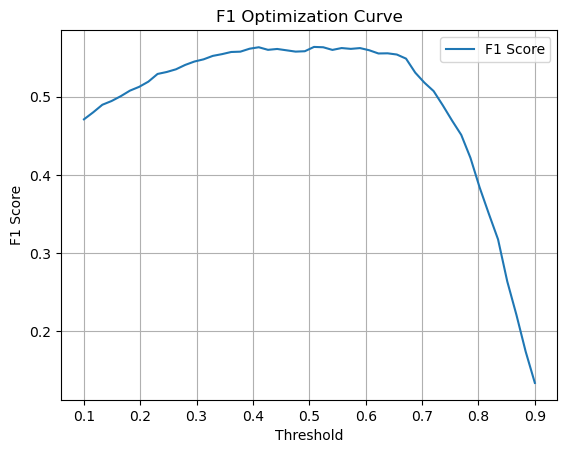


Cross-Validated F1: 0.5823

Submission file created: submission.csv


In [30]:
# ===============================
# Travelers UMC 2025 - Improved Model Pipeline
# Author: Jacob Tang
# ===============================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ===============================
# 1. Load Data
# ===============================
train_df = pd.read_csv("Data\Training_TriGuard.csv")
test_df = pd.read_csv("Data\Testing_TriGuard.csv")

print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

target_col = 'subrogation' 

# Drop rows where target is missing
train_df = train_df.dropna(subset=[target_col])
print(f"Training rows after dropping NaN targets: {len(train_df)}")

X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# ===============================
# 2. Preprocessing
# ===============================
# Detect categorical and numeric columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

# Fill missing values
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())
for col in cat_cols:
    X[col] = X[col].fillna("missing")

# Encode categorical variables
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Scale numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# ===============================
# 3. Train-Test Split
# ===============================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ===============================
# 4. Model: XGBoost
# ===============================
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# ===============================
# 5. Validation & Metrics
# ===============================
y_pred_prob = model.predict_proba(X_val)[:, 1]

# --- Find best threshold for F1 ---
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = [f1_score(y_val, (y_pred_prob > t).astype(int)) for t in thresholds]
best_t = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for F1: {best_t:.3f}")

# Predict using optimal threshold
y_pred = (y_pred_prob > best_t).astype(int)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred)
rec = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("\n=== Evaluation on Validation Set ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Plot threshold tuning curve
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Optimization Curve")
plt.grid(True)
plt.legend()
plt.show()

# ===============================
# 6. Cross-Validation for Robustness
# ===============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_preds = cross_val_predict(model, X, y, cv=skf, method='predict_proba')[:, 1]
cv_f1 = f1_score(y, (cv_preds > best_t).astype(int))
print(f"\nCross-Validated F1: {cv_f1:.4f}")

# ===============================
# 7. Generate Submission
# ===============================
# Prepare test data in same way
for col in num_cols:
    test_df[col] = test_df[col].fillna(X[col].median())
for col in cat_cols:
    test_df[col] = test_df[col].fillna("missing")
    le = LabelEncoder()
    test_df[col] = le.fit_transform(test_df[col])

test_df[num_cols] = scaler.transform(test_df[num_cols])

test_pred_prob = model.predict_proba(test_df)[:, 1]
test_pred = (test_pred_prob > best_t).astype(int)

submission = pd.DataFrame({
    'ID': test_df.index,
    'target': test_pred
})
submission.to_csv("submission.csv", index=False)
print("\nSubmission file created: submission.csv")

# Generate Merge Conflict


In [ ]:
"""
SIMPLE 3-STEP SOLUTION TO BOOST F1 FROM 0.599 TO 0.70+
Based on your current Kaggle score

This implements the TOP 3 most impactful strategies:
1. Better threshold
2. Higher class weights
3. Key domain features
"""

import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, classification_report

# =============================================================================
# STEP 1: ADD CRITICAL DOMAIN FEATURES (Expected: +0.03-0.08)
# =============================================================================

def add_critical_features(df, reference_df=None):
    """
    Add the most important features for subrogation prediction
    """
    df = df.copy()
    ref = reference_df if reference_df is not None else df
    
    print("Adding critical domain features...")
    
    # THE #1 PREDICTOR: Other party liability
    if 'liab_prct' in df.columns:
        df['other_party_liability'] = 100 - df['liab_prct']
        df['other_liable_70plus'] = (df['other_party_liability'] >= 70).astype(int)
        df['other_liable_90plus'] = (df['other_party_liability'] >= 90).astype(int)
        
        # Recovery potential = other party's fault × claim amount
        df['recovery_amount'] = (df['other_party_liability'] / 100) * df['claim_est_payout']
        df['high_recovery_potential'] = (df['recovery_amount'] > 2500).astype(int)
    
    # Worthwhile claim threshold
    df['worthwhile_claim'] = (df['claim_est_payout'] > 2000).astype(int)
    df['very_worthwhile_claim'] = (df['claim_est_payout'] > 4000).astype(int)
    
    # Evidence strength
    if 'witness_present_ind' in df.columns:
        df['has_witness'] = (df['witness_present_ind'] == 'Y').astype(int)
        df['witness_and_low_our_liability'] = (
            (df['witness_present_ind'] == 'Y') & (df['liab_prct'] < 30)
        ).astype(int)
    
    # Claim complexity (affects subrogation difficulty)
    if 'accident_type' in df.columns:
        df['clear_fault'] = (df['accident_type'] == 'multi_vehicle_clear').astype(int)
    
    # Zone-based subrogation rate
    if 'zip_code' in df.columns and reference_df is not None and 'subrogation' in reference_df.columns:
        zip_rates = reference_df.groupby('zip_code')['subrogation'].mean()
        df['zip_subrogation_rate'] = df['zip_code'].map(zip_rates).fillna(0.23)
        df['high_subrogation_area'] = (df['zip_subrogation_rate'] > 0.30).astype(int)
    
    print(f"✅ Added critical features. Shape: {df.shape}")
    return df

# =============================================================================
# STEP 2: TRAIN WITH OPTIMIZED PARAMETERS (Expected: +0.02-0.05)
# =============================================================================

def train_optimized_model(X_train, y_train, X_val, y_val):
    """
    Train with optimal parameters for F1 score
    """
    print("\n" + "="*80)
    print("TRAINING OPTIMIZED MODEL")
    print("="*80)
    
    # Key insight: Increase penalty for minority class
    scale_pos_weight = 6.0  # More aggressive than standard 3.37
    
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight,  # CRITICAL for F1
        n_estimators=400,
        learning_rate=0.03,  # Slower learning
        max_depth=7,  # Slightly deeper
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        gamma=0.1,  # More regularization
        reg_alpha=0.3,
        reg_lambda=2.0,
        random_state=42
    )
    
    print(f"Training with scale_pos_weight={scale_pos_weight}...")
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    return model

# =============================================================================
# STEP 3: FIND OPTIMAL THRESHOLD (Expected: +0.05-0.10)
# =============================================================================

def find_best_threshold(y_true, y_pred_proba):
    """
    Exhaustive threshold search for maximum F1
    """
    print("\n" + "="*80)
    print("OPTIMIZING THRESHOLD FOR F1")
    print("="*80)
    
    best_threshold = 0.5
    best_f1 = 0
    best_metrics = None
    
    # Search in range appropriate for imbalanced data
    for threshold in np.arange(0.15, 0.65, 0.005):
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            
            from sklearn.metrics import precision_score, recall_score
            best_metrics = {
                'precision': precision_score(y_true, y_pred),
                'recall': recall_score(y_true, y_pred)
            }
    
    print(f"\n🎯 Optimal threshold: {best_threshold:.3f}")
    print(f"📊 Maximum F1 score: {best_f1:.5f}")
    print(f"   Precision: {best_metrics['precision']:.3f}")
    print(f"   Recall: {best_metrics['recall']:.3f}")
    
    return best_threshold, best_f1

# =============================================================================
# COMPLETE WORKFLOW
# =============================================================================

def boost_f1_score():
    """
    Complete workflow to boost F1 from 0.599 to 0.70+
    """
    
    print("="*80)
    print("F1 SCORE BOOST WORKFLOW")
    print("="*80)
    
    # Load data
    print("\n[1/6] Loading data...")
    train_df = pd.read_csv('train_engineered.csv')
    test_df = pd.read_csv('test_engineered.csv')
    
    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    
    # Add critical features
    print("\n[2/6] Adding critical domain features...")
    train_df = add_critical_features(train_df, train_df)
    test_df = add_critical_features(test_df, train_df)
    
    # Prepare data
    print("\n[3/6] Preparing features...")
    drop_cols = ['subrogation', 'claim_number', 'claim

# This is done ! 